# Sheet 11

To run in Google Colab (highly recommended for exercise 3) go to: 
https://colab.research.google.com/drive/1kEEEyD_8uFzl97g7nzeEz5UEBKjpBD48?usp=sharing

## 1 Positional Encoding

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from tqdm.auto import tqdm

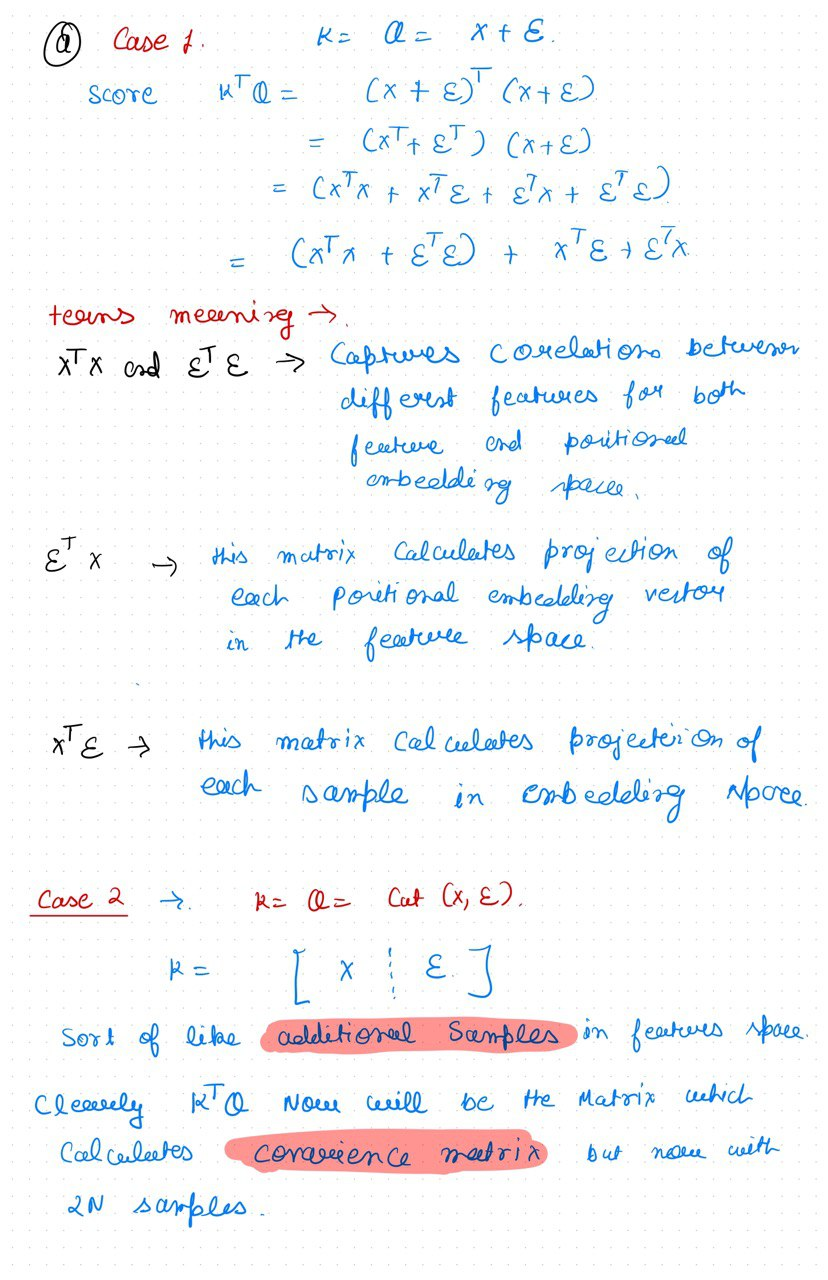

In [2]:
from IPython.display import Image

Image(filename = '1.(a).jpg')

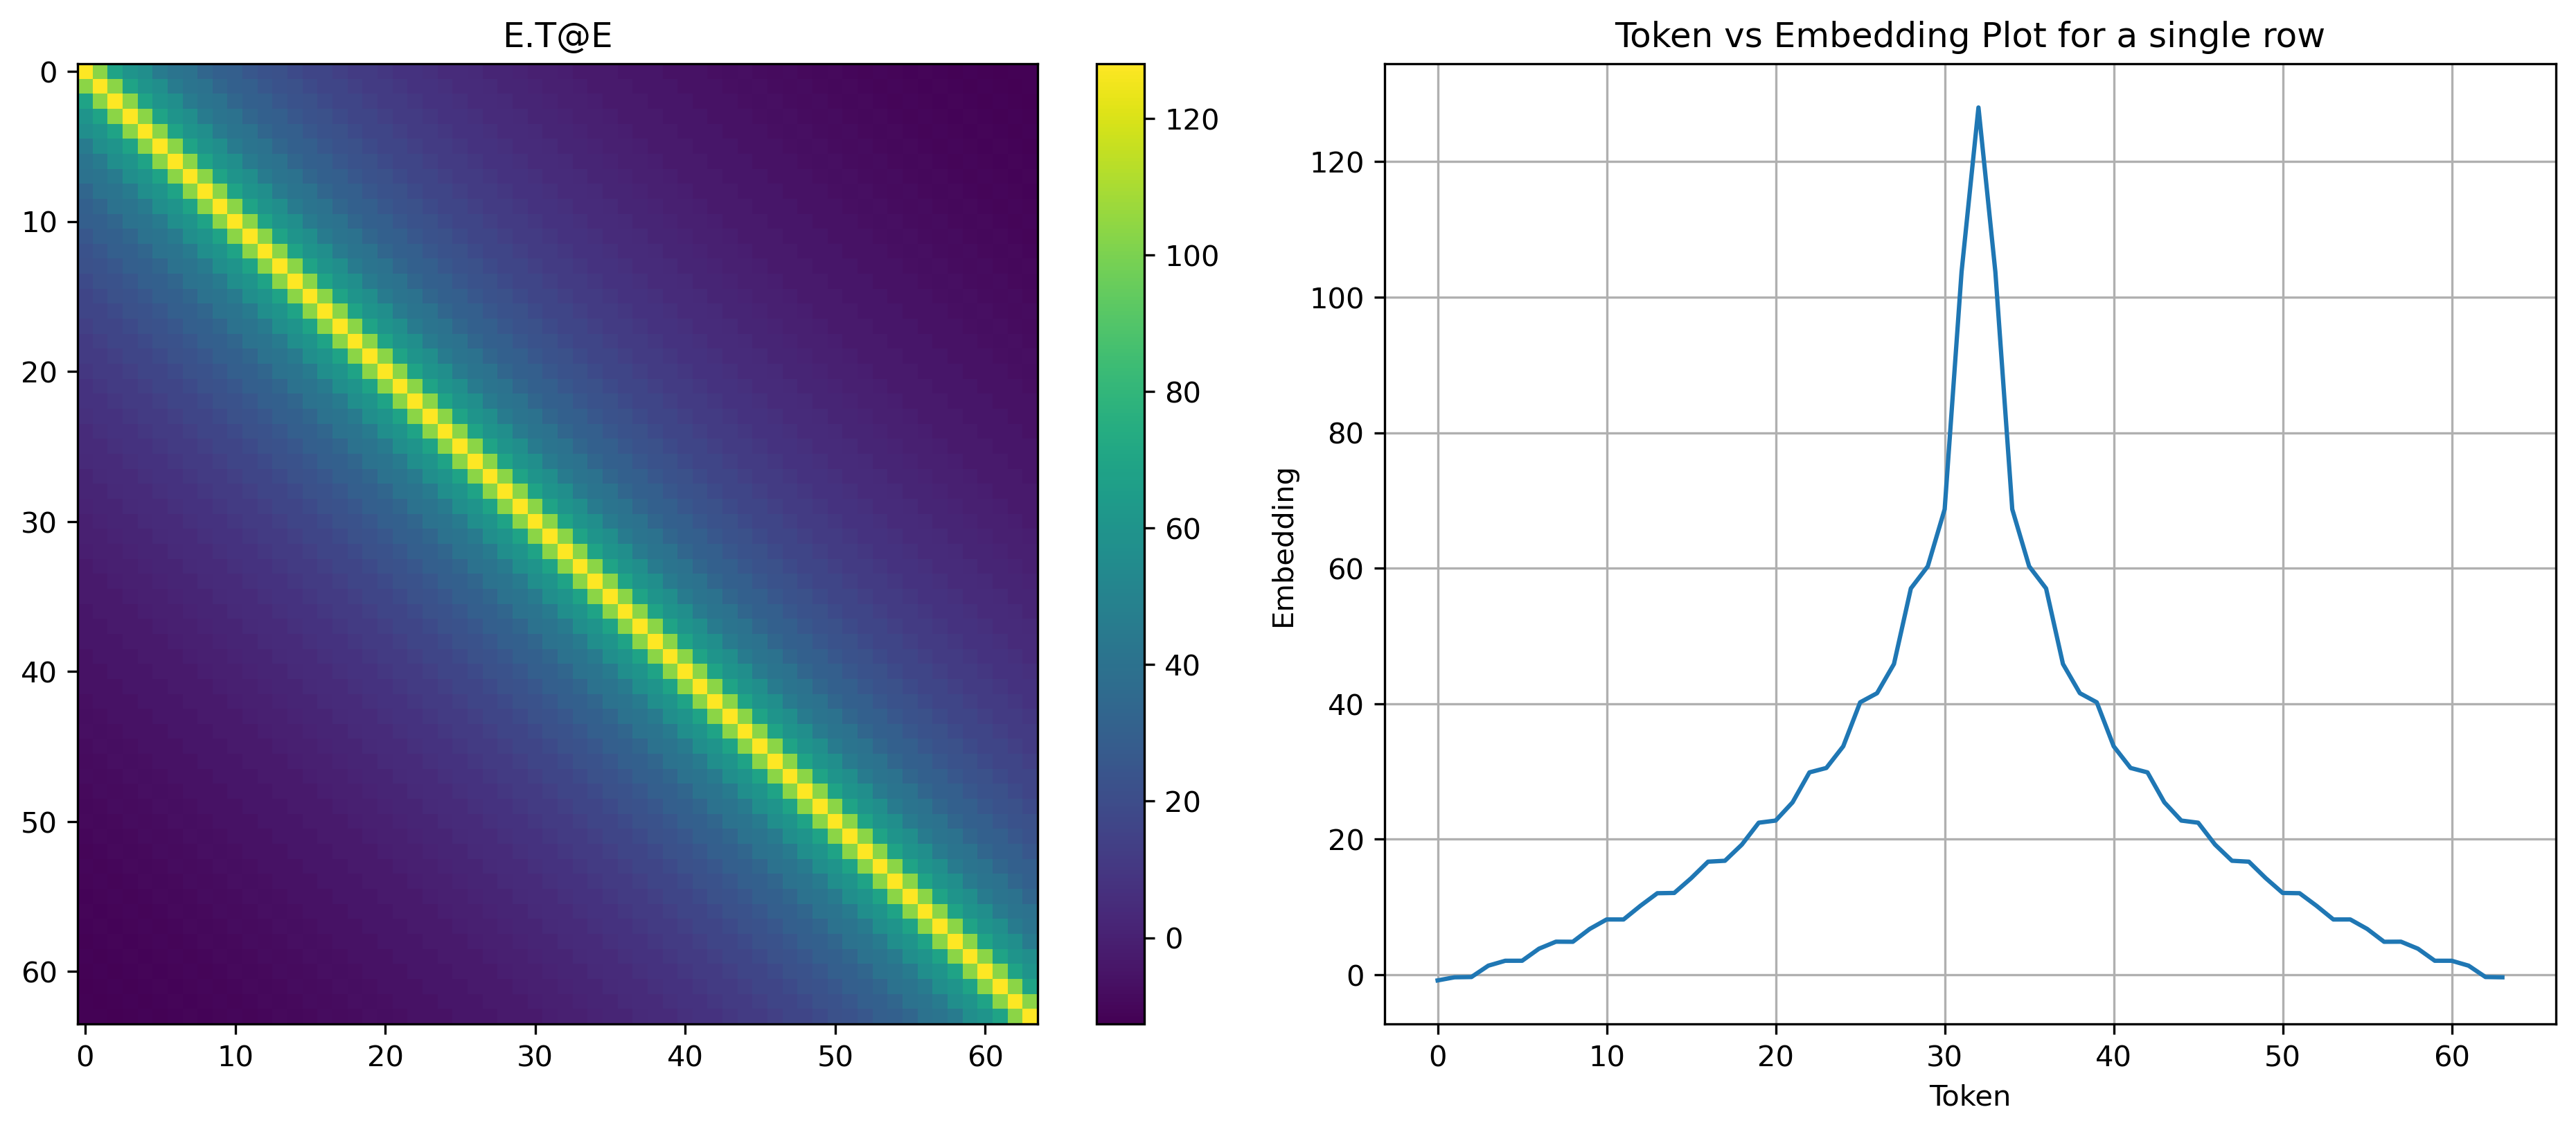

In [5]:
p = 256 # embedding dimension 
N = 64  # tokens

E = np.zeros((p,N))

for k in range(int(p/2)):
    for i in range(0,N):
        exp = np.exp(-(k*np.log(10000))/p)
        E[2*k,i] = np.sin(2*i*exp)
        E[2*k+1,i] = np.cos(2*i*exp)

matrix = E.T@E
fig,ax = plt.subplots(1,2,figsize=(16,6),dpi=300)
ax[0].set_title('E.T@E')
im = ax[0].imshow(matrix)
plt.colorbar(im, ax=ax[0],fraction=0.046)

step = np.arange(0,64)
ax[1].plot(step,matrix[32,:])
ax[1].set_xlabel('Token')
ax[1].set_ylabel('Embedding')
ax[1].set_title('Token vs Embedding Plot for a single row')
ax[1].grid()

- We see that each embedding dimension is highly correlated with itself, therefore getting the highly dense diagonal.
  
- As we move away from one dimension to other the covariance oscillates and 'dies' exponentially. 
  
- This means that a particular random feature is correlated to its nearest features locally. As we move away this correlation becomes zero. 
  
- To demonstrate and support our reasoning, we have also plotted a particular row. 

### 1.(C)

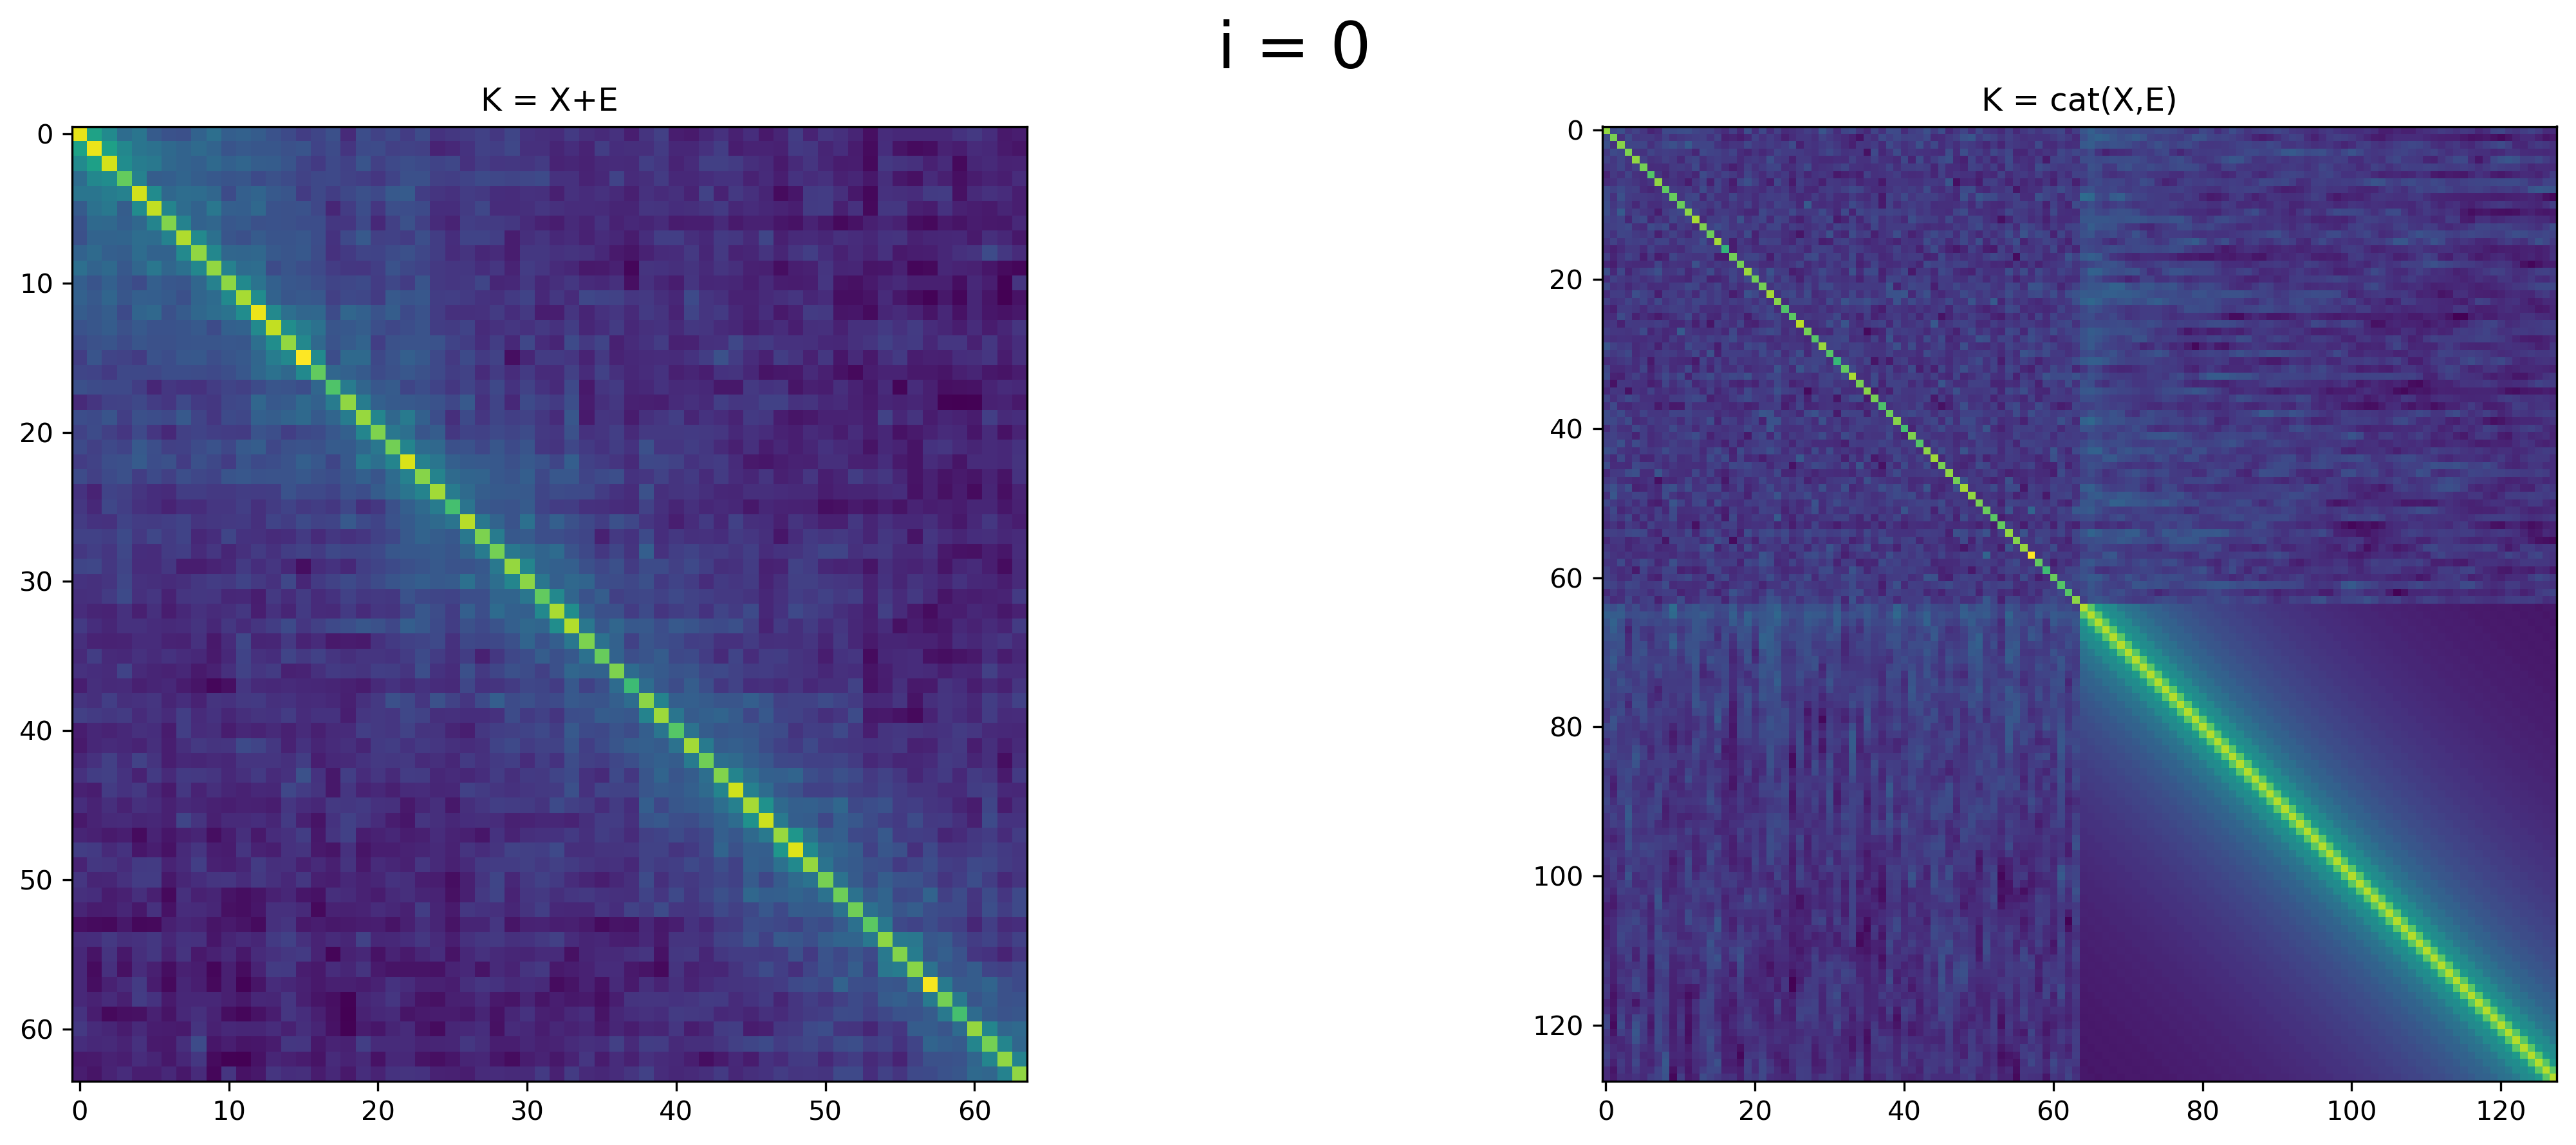

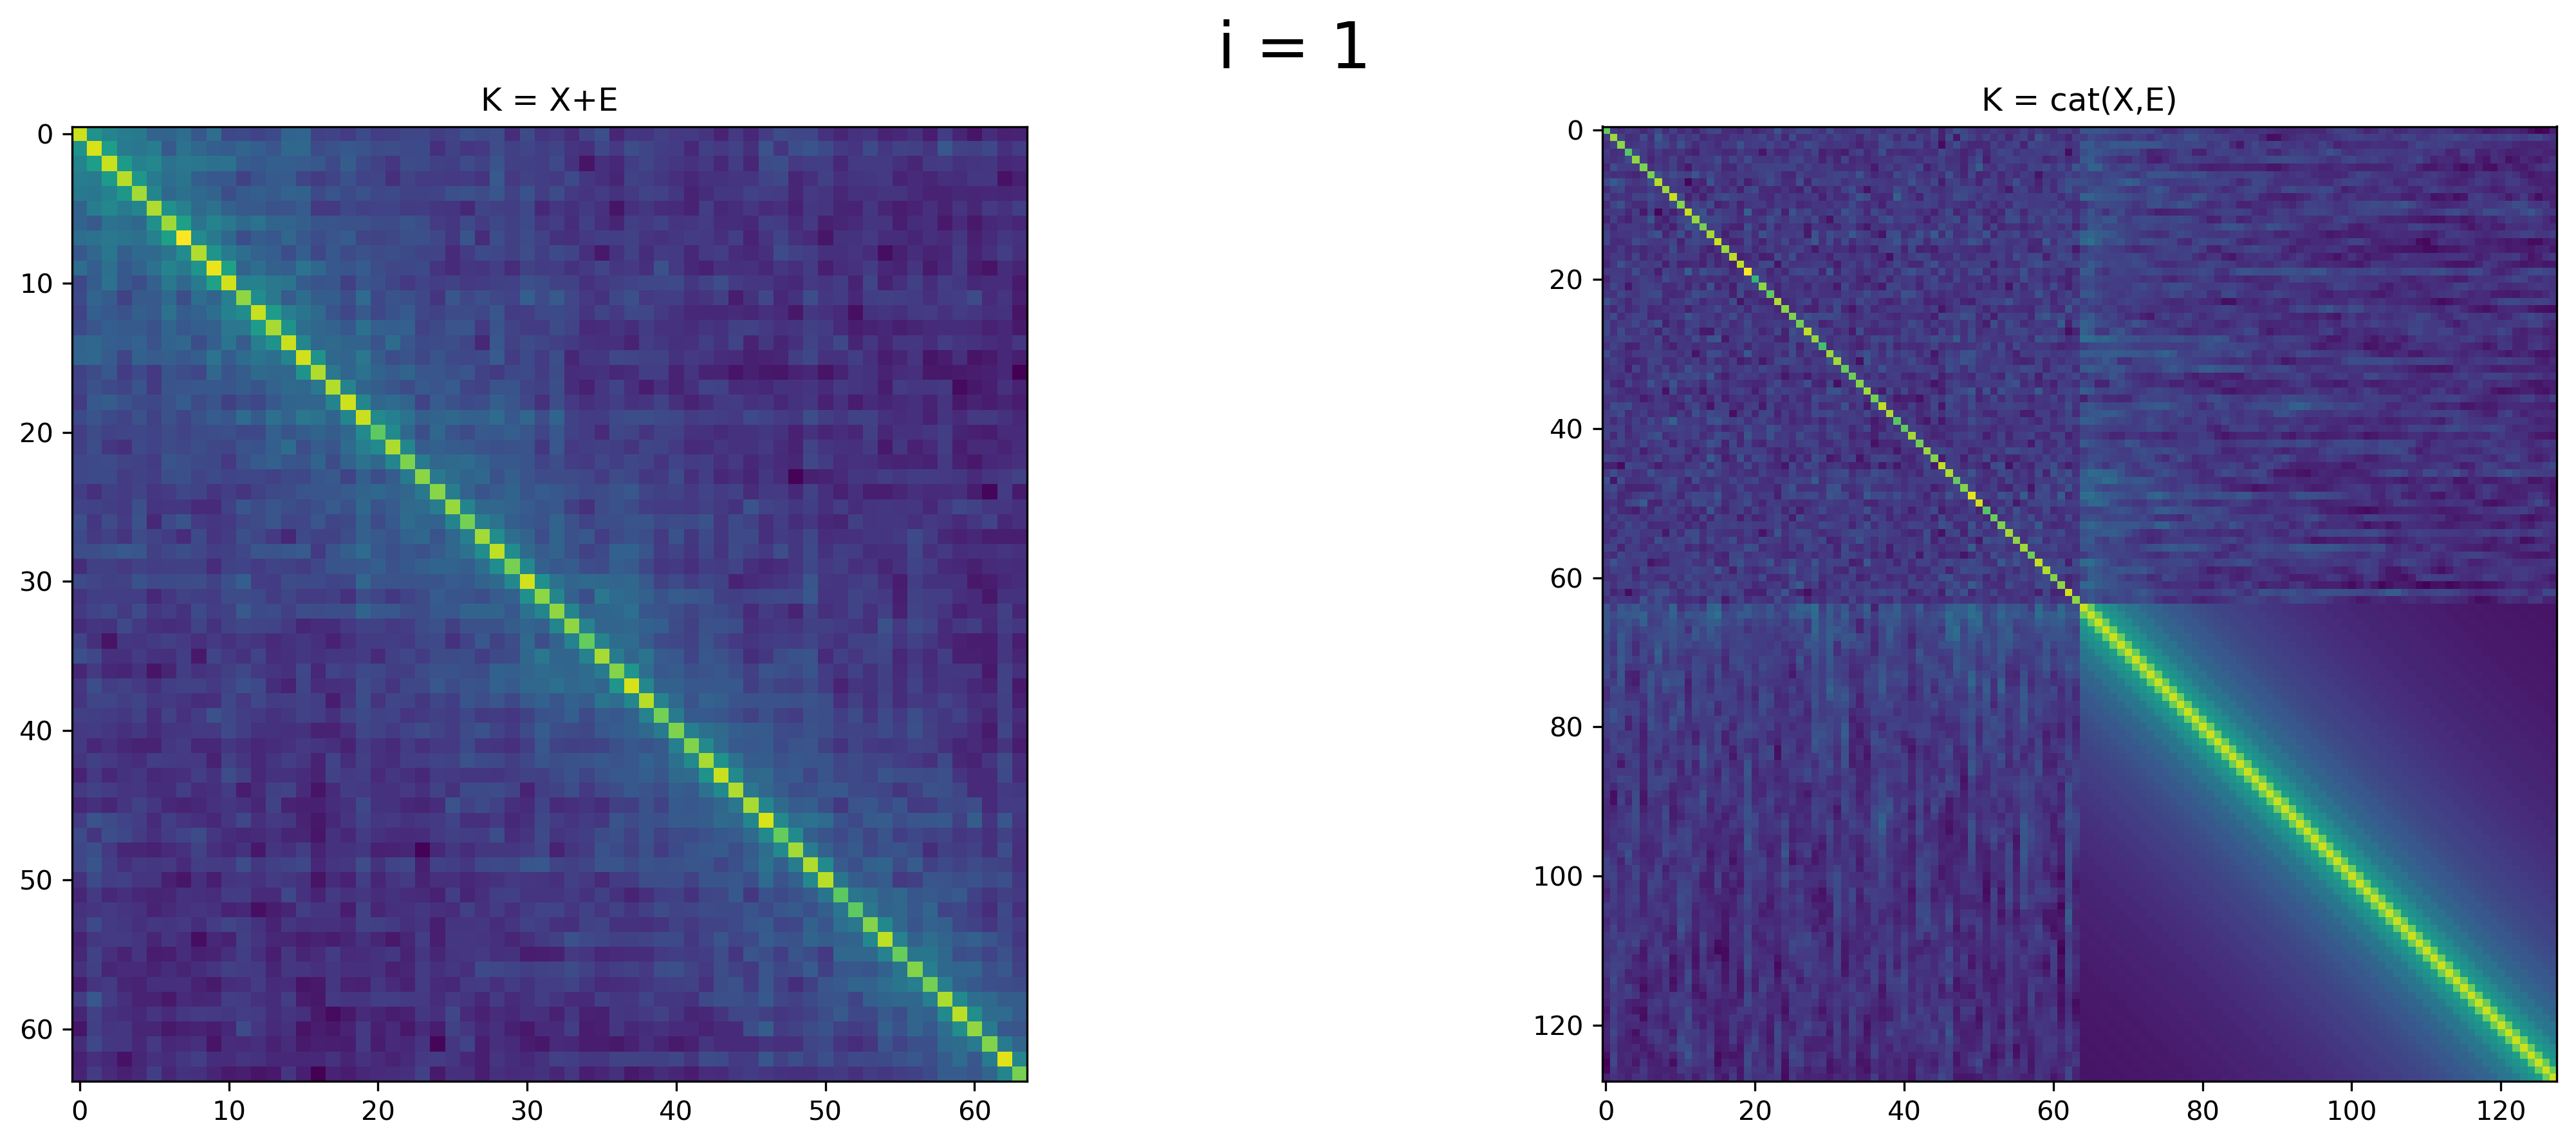

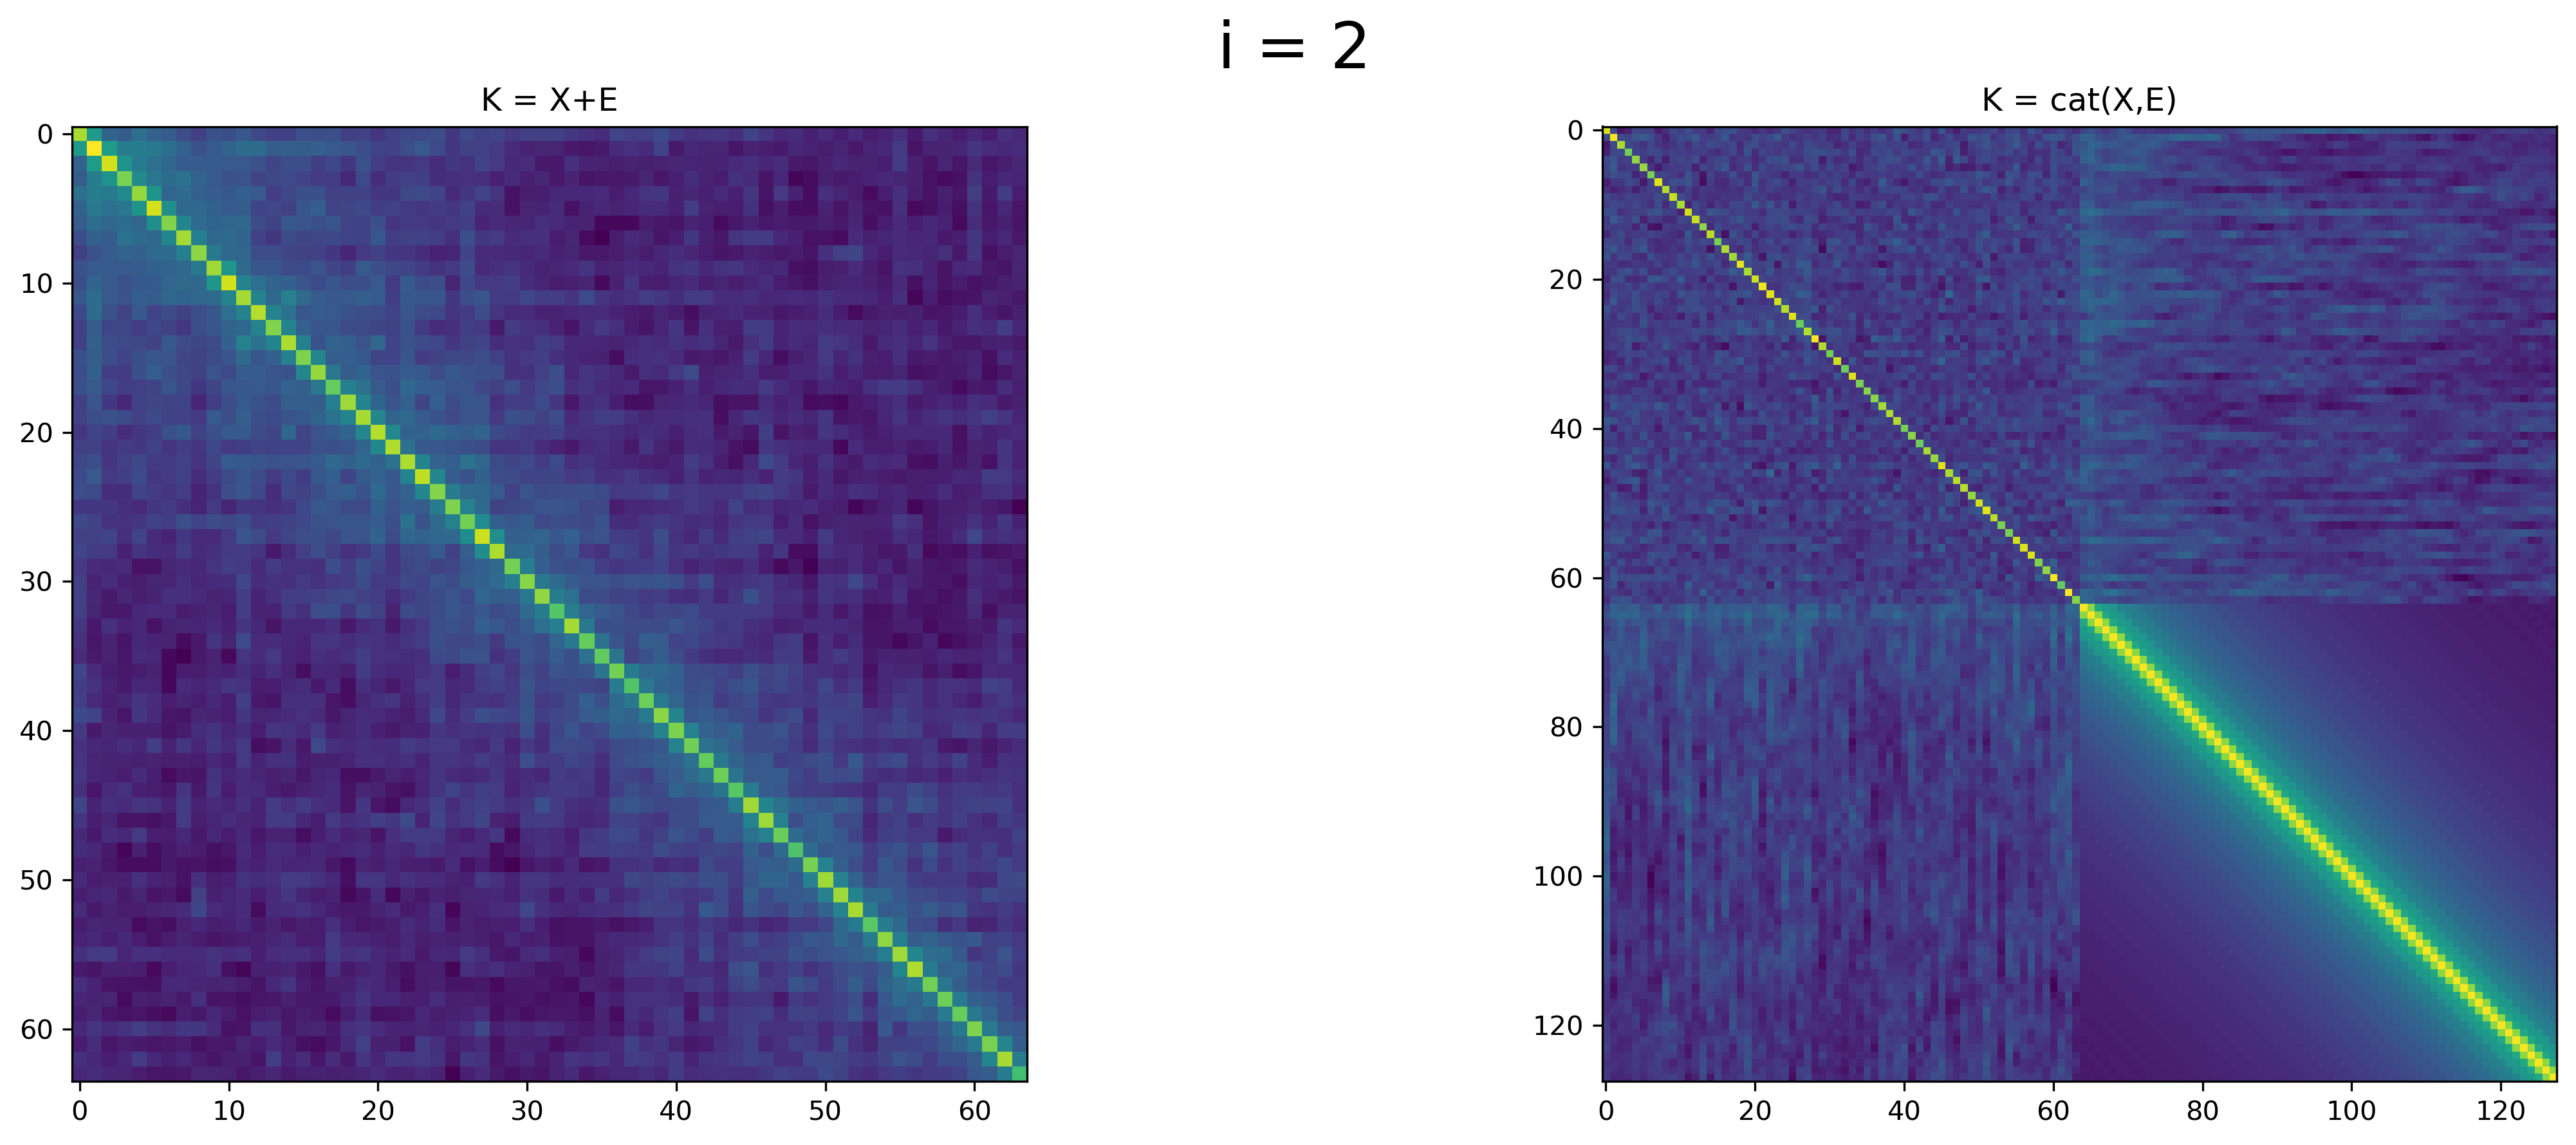

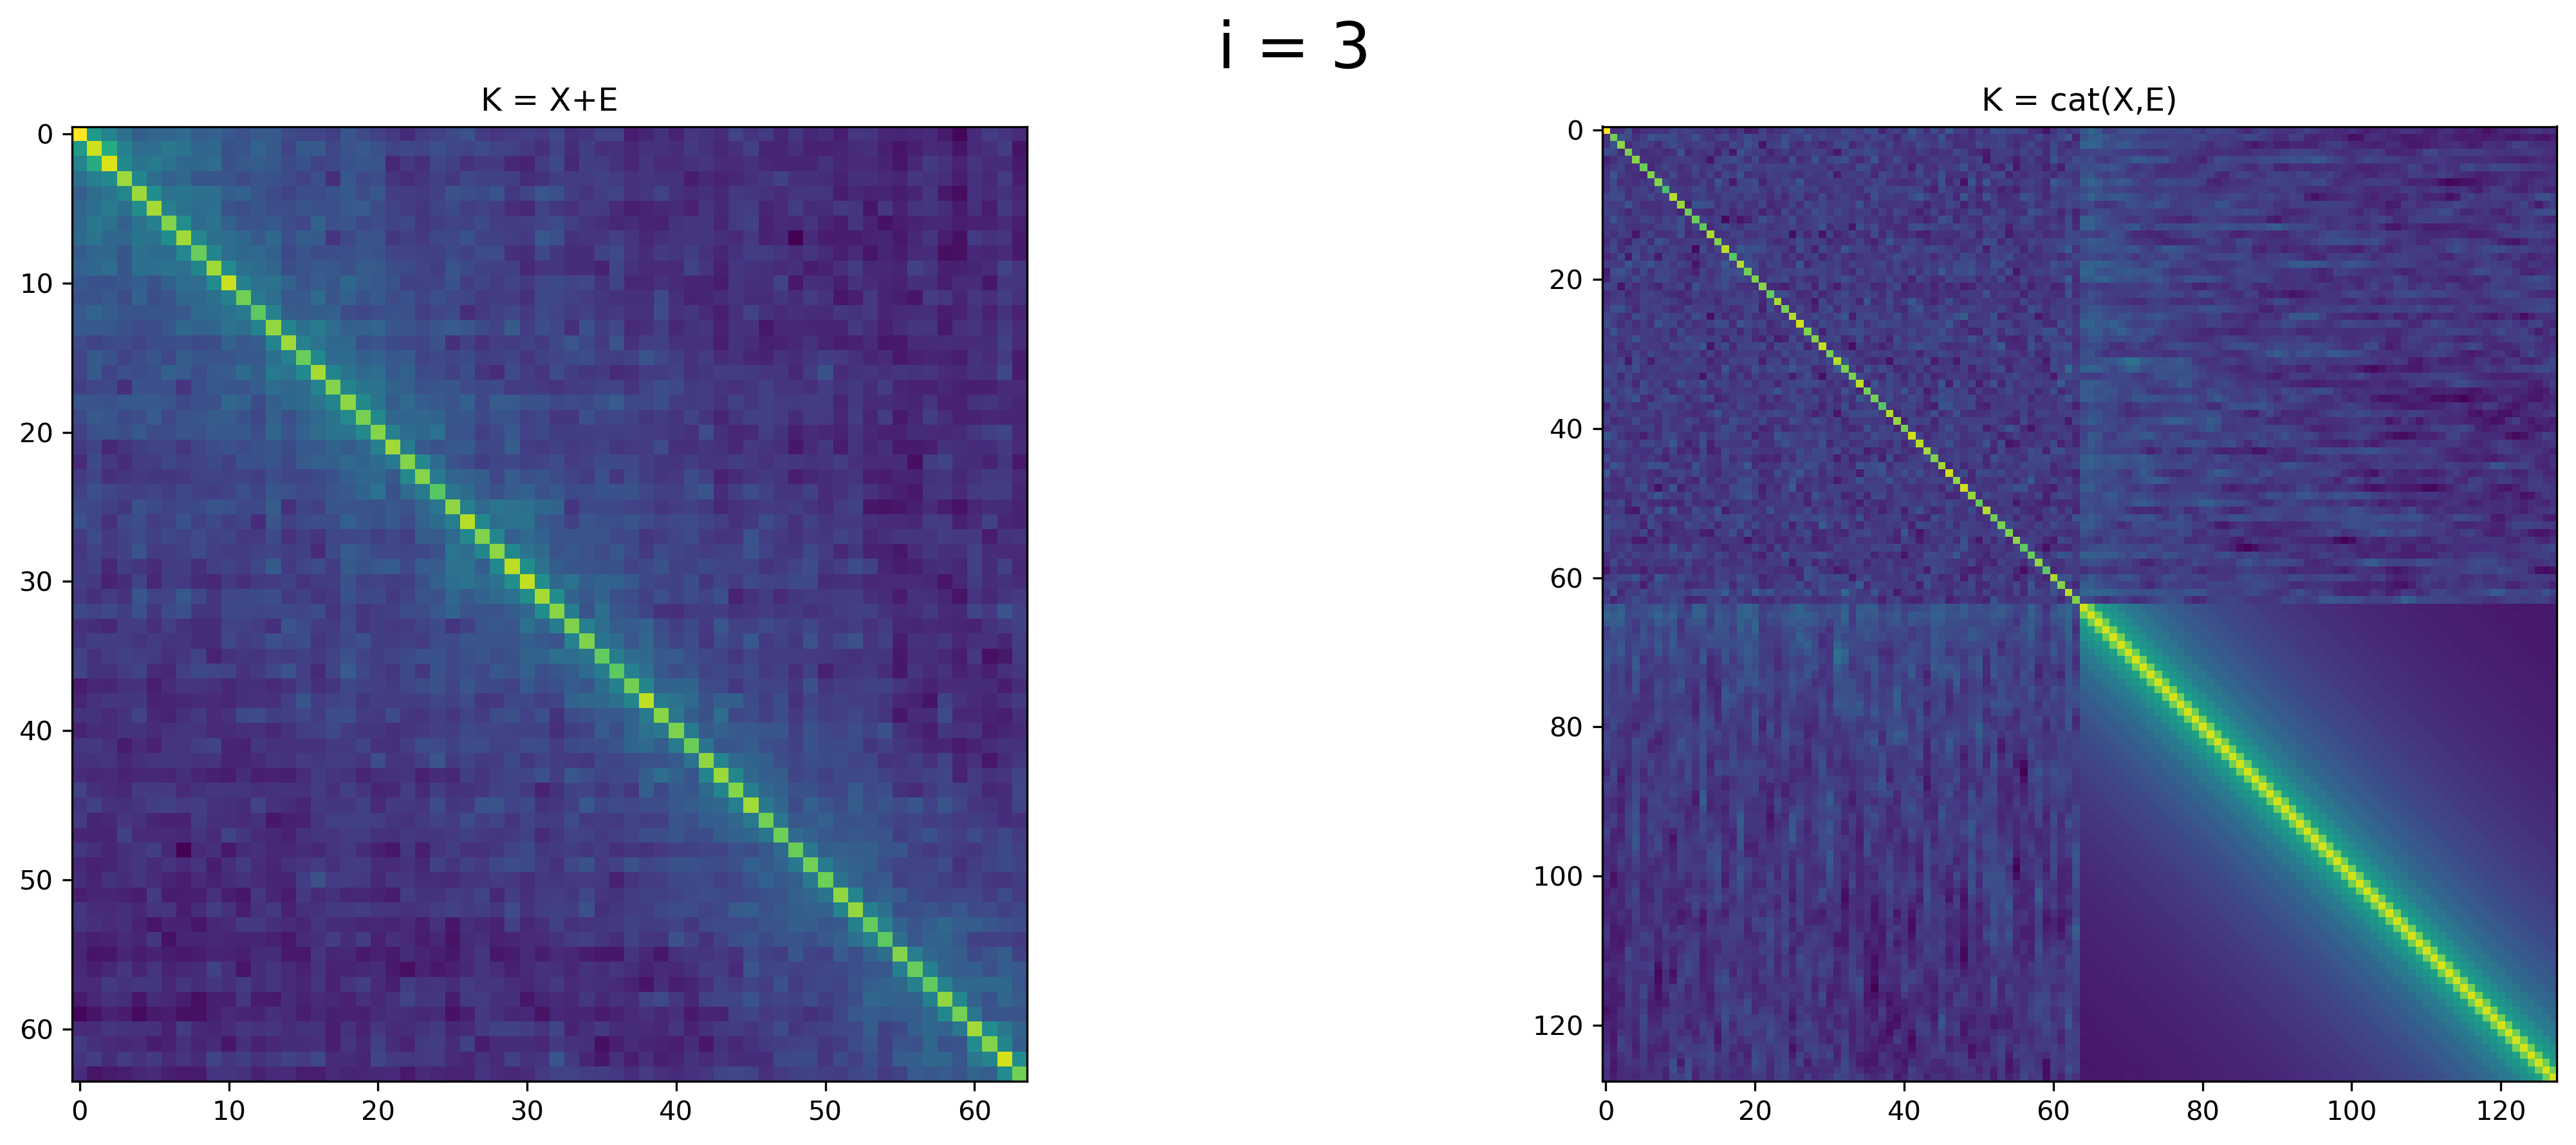

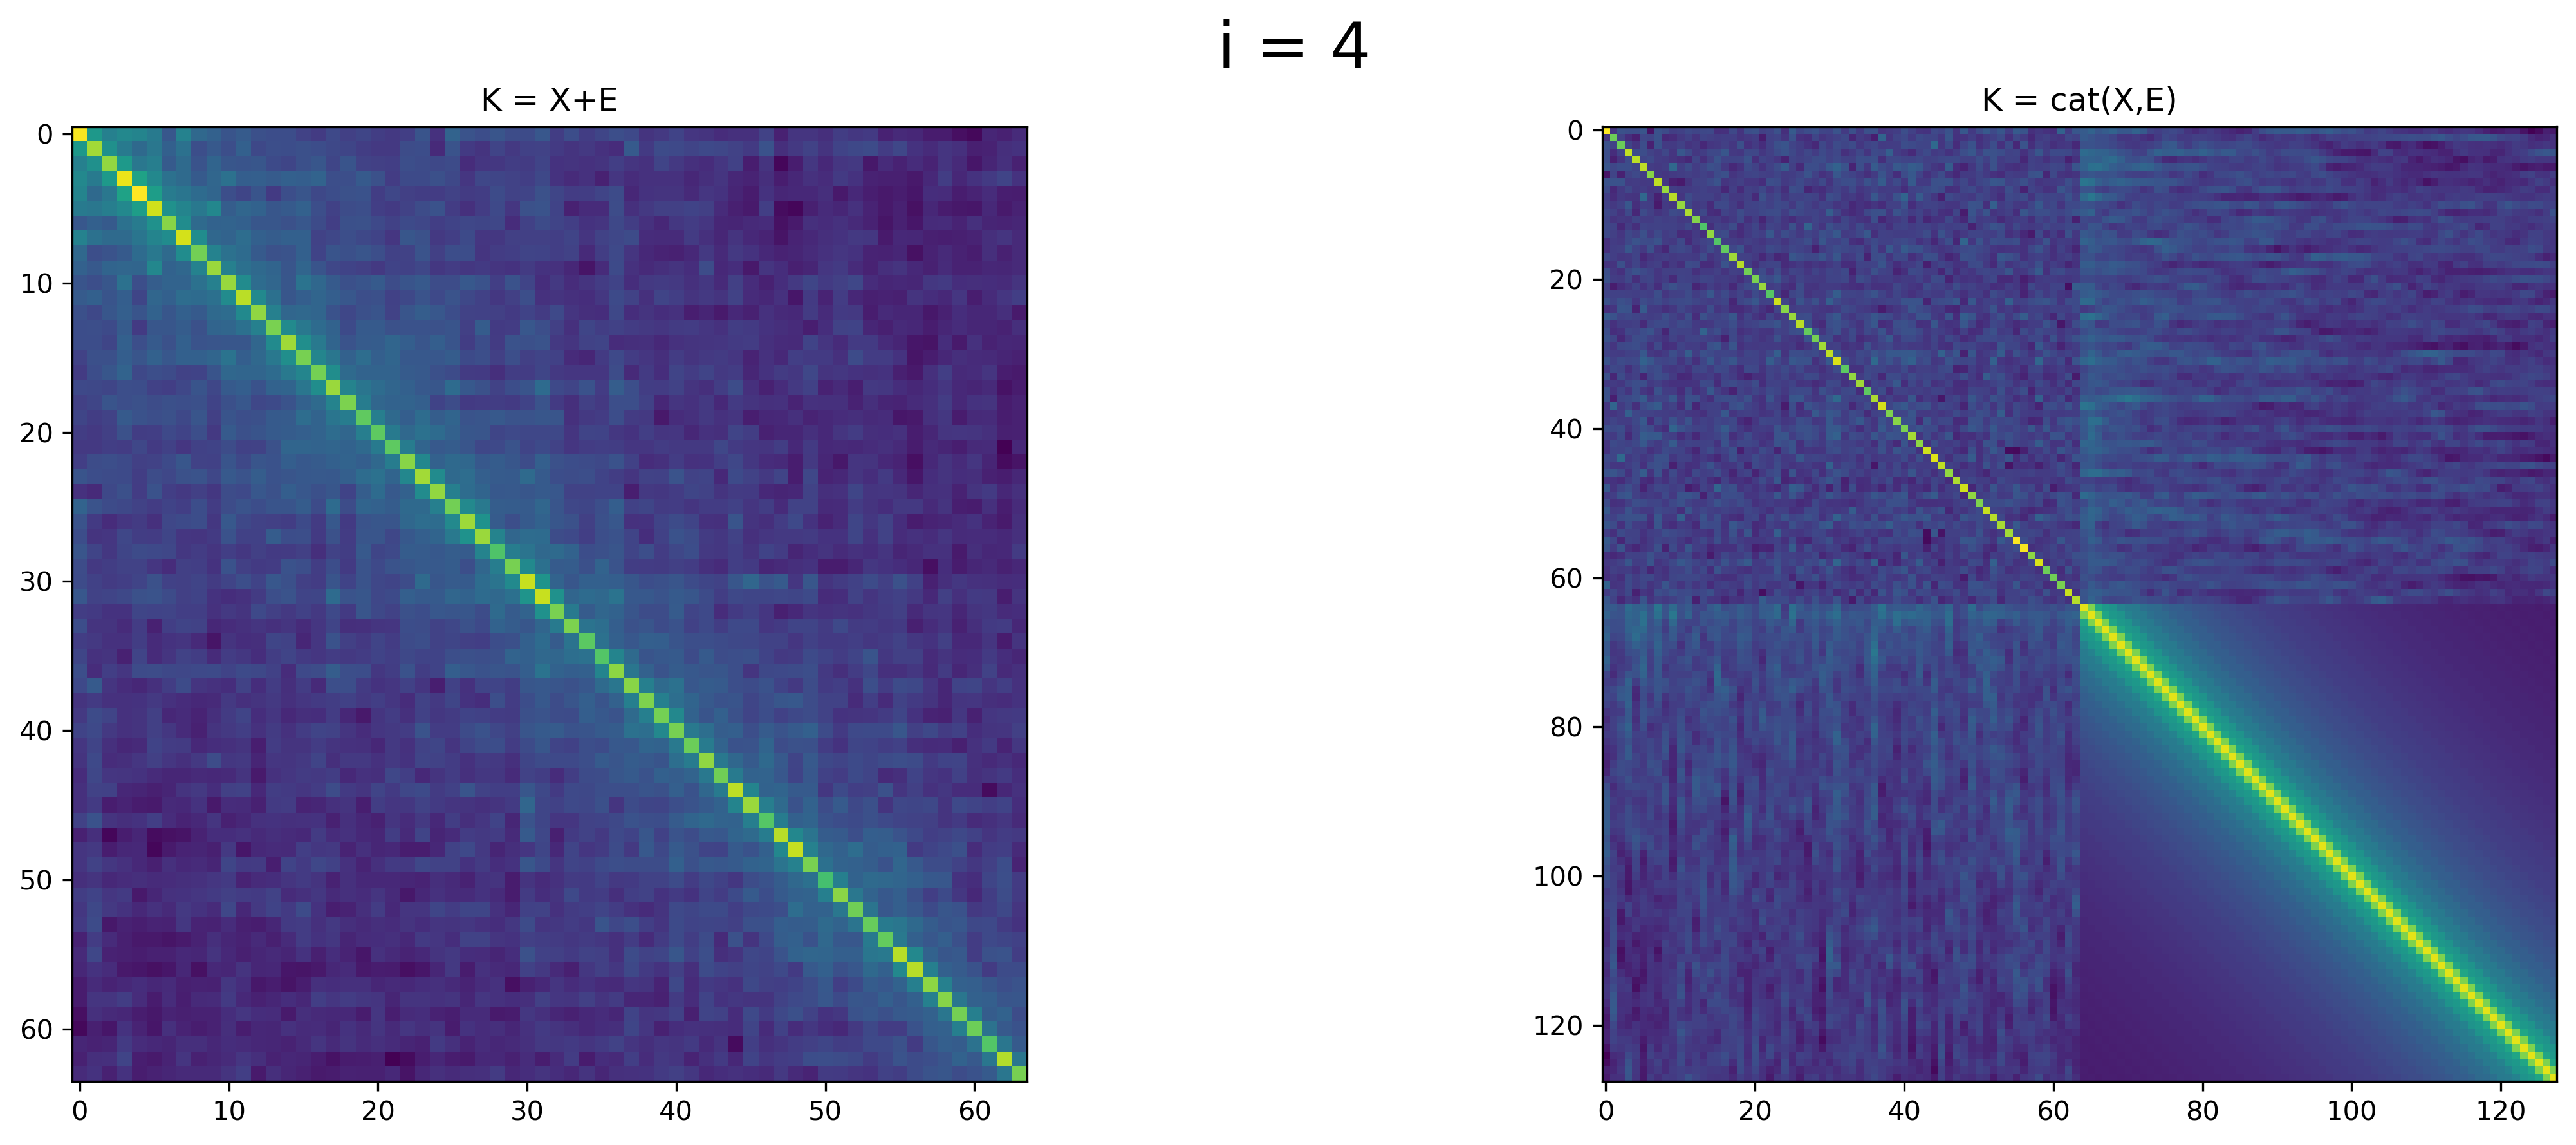

In [6]:
# calculating the variance of E along axis = 1 and taking the average
var = np.mean(np.var(E,axis =1))
mean = np.mean(np.mean(E,axis = 1))

# generating (p X N) elements from a gaussian with different mean and sigma
mu = np.mean(mean)
sigma = np.sqrt(var)


for i in range(5):  ## we will plot the scores for 5 different random features which has the same sigma and mean like E
    X = np.random.normal(mu,sigma,size = (p,N))
    K = X + E
    fig,ax = plt.subplots(1,2,figsize=(16,6),dpi=300)
    fig.suptitle(f'{i = }',size=24)
    fig.tight_layout()
    ax[0].imshow(K.T@K)
    ax[0].set_title('K = X+E')

    K = np.hstack((X,E))
  
    ax[1].set_title('K = cat(X,E)')

    ax[1].imshow(K.T@K)

- We see that for `K = X+E`, the scores peak at the diagonal (same feature) and as we move away from the diagonal (particular feature) covariance is distributed randomly.

- For the concatenated part, `cat(X,E)`, the image is divided into three main parts:
  - The top left and top right parts capture the covariance matrix of the feature and embedding space. 
  
  - Whereas, the off-diagonal part captures covariance between features and embedding space

- We can also say that the `K = (X+E)` part is just the summed version of all constituents part of `cat(X,E)`.


## 3 Observing Oversmoothing

In [ ]:
#@title Install Dependencies and get data from GitHub (will take a few minutes)
# install dependencies
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install mamba -y
!mamba install -c rusty1s -c pytorch -c conda-forge -c lcerrone ctg-benchmark cpuonly torchmetrics=0.8.0 jupyter matplotlib

# get data from github
!git clone https://github.com/hci-unihd/mlph_sheet11/
!mv mlph_sheet11/ctg_data .

In [3]:
from ctg_benchmark.loaders.torch_loader import get_cross_validation_loaders, get_split_loaders
from ctg_benchmark.evaluation.metrics import NodeClassificationMetrics, aggregate_class
import torch
import numpy as np
from tqdm import trange
from tqdm.auto import tqdm
from torch_geometric.nn.models import GCN
from torch.optim import Adam
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [93]:
def validation(validation_loader, model):
    # set up evaluation
    eval_metrics = NodeClassificationMetrics(num_classes=9)

    accuracy_records, accuracy_class_records = [], []
   
    model.eval()
    # TODO: add calculation of mean feature std
    with torch.no_grad():
        val_loss  = 0
        std_batch = 0

        for val_batch in validation_loader:
            val_batch = val_batch.to(device)
            pred = model.forward(val_batch.x, val_batch.edge_index)
            logits = torch.log_softmax(pred, 1)
            pred = logits.max(1)[1]

            std_batch += torch.std(logits).item()

            V_loss_func = F.nll_loss(logits, val_batch.y)
            val_loss  += V_loss_func.item()
            # results is a dictionary containing a large number of classification metrics
            results = eval_metrics.compute_metrics(pred.cpu(), val_batch.y.cpu())
            acc = results['accuracy_micro']
            # aggregate class average the single class accuracy and ignores the embryo sack class (7)
            acc_class, _ = aggregate_class(results['accuracy_class'], index=7)

            accuracy_records.append(acc)
            accuracy_class_records.append(acc_class)

        val_loss /= len(validation_loader)

        stds = std_batch/len(validation_loader)


    return accuracy_records, accuracy_class_records,val_loss,stds


def simple_trainer(trainer_loader, validation_loader,num_layers=2):

    '''
    We modified this function such that it calls  upper validation function and returns both train loss 

    validation loss

    '''
    model = GCN(in_channels=74, hidden_channels=64, num_layers=num_layers, out_channels=9, dropout=0.5)
    model = model.to(device)
    optim = Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-5)
    t_range = trange(25, desc=f'Epoch: {0: 03d}, training loss: {0/len(trainer_loader): .2f}')
    # basic training loop
    t_loss = []
    v_loss = []
    for epoch in t_range:
        loss_epoch = 0
        for batch in trainer_loader:
            optim.zero_grad()
            batch = batch.to(device)
            pred = model.forward(batch.x, batch.edge_index)
            logits = torch.log_softmax(pred, 1)
            loss = F.nll_loss(logits, batch.y)
            loss.backward()

            optim.step()
            loss_epoch += loss.item()
        

        t_range.set_description(f'Epoch: {epoch + 1: 03d}, training loss: {loss_epoch/len(trainer_loader): .2f}')
        t_range.refresh()
        t_loss.append(loss_epoch/len(trainer_loader))

        a_r,a_c_r,val_loss,stds = validation(validation_loader,model)
        v_loss.append(val_loss)

        ##once the training is done we pass our model to validation and c



    return model,t_loss,v_loss

#### Training GCN with 2 layers

Epoch:  25, training loss:  0.54: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]



GCN results for num_layers=2:
Accuracy 0.749 std: 0.041
Class Accuracy 0.652 std: 0.081


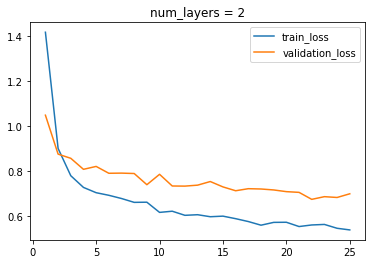

In [94]:
loaders = get_split_loaders(root='./ctg_data', batch_size=1, shuffle=True, grs=('label_grs_surface',))
training_loader, validation_loader = loaders['train'], loaders['val']

# example training for GCN with 1 layer
num_layers  = 2
model,t_loss,v_loss =  simple_trainer(training_loader, validation_loader, num_layers=num_layers)
accuracy_records, accuracy_class_records,val_loss,stds = validation(validation_loader, model)

# report results
print(f'\nGCN results for {num_layers=}:')
print(f'Accuracy {np.mean(accuracy_records):.3f} std: {np.std(accuracy_records):.3f}')
print(f'Class Accuracy {np.mean(accuracy_class_records):.3f} std: {np.std(accuracy_class_records):.3f}')


epoch = np.arange(1,26)
plt.plot(epoch,t_loss,label = "train_loss")
plt.plot(epoch,v_loss,label = "validation_loss")
plt.title("num_layers = "+str(num_layers))
plt.legend()
plt.show()

#### Repeating the same task for num_layers 1,5 and 20

Epoch:  25, training loss:  1.84: 100%|██████████| 25/25 [03:19<00:00,  7.98s/it]


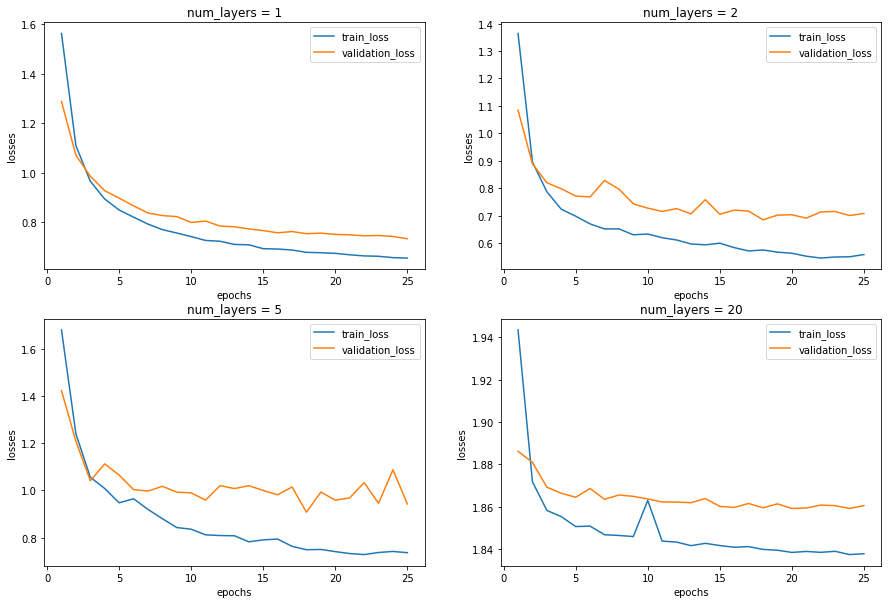

In [98]:
epoch = np.arange(1,26)

from matplotlib import pyplot as plt

num_layers_arr = [1,2,5,20]
fig,axs = plt.subplots(2,2,figsize = (15,10))
Models = [model] ##storing 

for num_layers,ax in zip(num_layers_arr,axs.flatten()):

    loaders = get_split_loaders(root='./ctg_data', batch_size=1, shuffle=True, grs=('label_grs_surface',))
    training_loader, validation_loader = loaders['train'], loaders['val']


    model,t_loss,v_loss =  simple_trainer(training_loader, validation_loader, num_layers=num_layers)
    ax.plot(epoch,t_loss,label = "train_loss")
    ax.plot(epoch,v_loss,label = "validation_loss")
    ax.set_title("num_layers = "+str(num_layers))
    ax.set_xlabel("epochs")
    ax.set_ylabel("losses")
    ax.legend()



    Models.append(model)
plt.show()

 - In the performance, plots show us that the model with a single layer performs badly as compared to multiple layers. 
  
 - We can confirm this by the increment in the validation error as the model progresses through the epochs. 
  
 - This is also intuitive as more the no. of layers, better will the model but we also need to take care of efficiency and computation time trade-off. 

#### Computing standard deviations for each for the train models

In [103]:
for num_layers,model in zip(num_layers_arr,Models):
    A,B,V,std = validation(validation_loader,model)

    print(f'{num_layers = }, {std = }')

num_layers = 1, std = 11.968959728876749
num_layers = 2, std = 4.435128013292949
num_layers = 5, std = 11.36930227279663
num_layers = 20, std = 10.394613981246948
